### Setup

In [1]:
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
style.use('ggplot')

/usr/local/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load Dataset and Randomization

In [2]:
mnist_dataframe = pd.read_csv(
    io.open("mnist_train_small.csv", "r"),
    sep=",",
    header=None)
mnist_dataframe = mnist_dataframe.head(10000) # first 10000 rows
mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
5309,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7541,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2548,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6207,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5983,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
display.display(mnist_dataframe.loc[3:10, 50:100])
display.display(mnist_dataframe[0])
display.display(mnist_dataframe.loc[:, 1:784])

,50,51,52,53,54,55,56,57,58,59,...,91,92,93,94,95,96,97,98,99,100
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
574,0,0,0,0,0,0,0,0,0,0,...,0,37,252,143,0,0,0,0,0,0
6933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,239,253,227,36
5416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,114,254,227,140,0
1205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


5309    8
7541    8
2548    5
6207    8
5983    1
       ..
4479    6
4948    3
3315    5
1749    2
9568    4
Name: 0, Length: 10000, dtype: int64

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
5309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4948,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1749,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Parse out Labels and Features

In [4]:
# Column0 represent labels
# Column1 through Column784 represent features --> gray scale pixels
def parse_labels_and_features(dataset):
    labels = dataset[0]
    
    # DataFrame.loc index ranges are inclusive at both ends
    features = dataset.loc[:, 1:784]
    # Scale the data to [0, 1] by dividing out the max value, 255.
    features = features / 255
    return labels, features

### Training set and Validation set

In [5]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
print("Training Targets Summary: ")
display.display(training_targets.describe())
print("Training Examples Summary: ")
display.display(training_examples.describe())

validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
print("Validation Targets Summary: ")
display.display(validation_targets.describe())
print("Validation Examples Summary: ")
display.display(validation_examples.describe())

Training Targets Summary: 


count   7500.0
mean       4.5
std        2.9
min        0.0
25%        2.0
50%        4.0
75%        7.0
max        9.0
Name: 0, dtype: float64

Training Examples Summary: 


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.2,1.0,0.2,0.0,0.0,0.0,0.0


Validation Targets Summary: 


count   2500.0
mean       4.5
std        2.9
min        0.0
25%        2.0
50%        4.0
75%        7.0
max        9.0
Name: 0, dtype: float64

Validation Examples Summary: 


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Random Example and its corresponding Label

1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
       ..
780   0.0
781   0.0
782   0.0
783   0.0
784   0.0
Name: 8809, Length: 784, dtype: float64

4

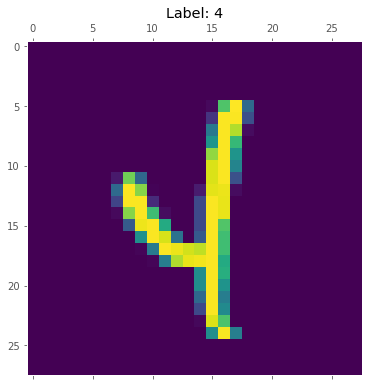

In [26]:
rand_example = np.random.choice(training_examples.index)
display.display(training_examples.loc[rand_example])
display.display(training_targets.loc[rand_example])
plt.figure(figsize=(8, 6))
plt.matshow(training_examples.loc[rand_example].values.reshape(28, 28), fignum=1)
plt.title("Label: %i" % training_targets.loc[rand_example])
plt.grid(False)

In [27]:
mnist_dataframe.loc[rand_example]

0      4
1      0
2      0
3      0
4      0
      ..
780    0
781    0
782    0
783    0
784    0
Name: 8809, Length: 785, dtype: int64